In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from src.utils import cluster_accuracy
from src.clutad.model import CluTaD
from src.clutad.encoder import TabularEncoder
from src.clutad.denoiser import Denoiser

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd


def plot_clusters_2d(X, y_true, y_pred, title_prefix="Dataset"):
    # Reduce to 2D if necessary
    if X.shape[1] > 2:
        #X_2d = PCA(n_components=2).fit_transform(X)
        X_2d = TSNE(n_components=2, random_state=42).fit_transform(X)
    else:
        X_2d = X

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # True clusters
    scatter1 = axes[0].scatter(X_2d[:,0], X_2d[:,1], c=y_true, cmap="tab10", s=25)
    axes[0].set_xlabel("t-SNE 1")
    axes[0].set_ylabel("t-SNE 2")
    axes[0].set_title(f"a) t-SNE embeddings of true clusters", y=-0.2)  # move title below
    legend1 = axes[0].legend(*scatter1.legend_elements(), title="Clusters")
    axes[0].add_artist(legend1)

    # Predicted clusters
    scatter2 = axes[1].scatter(X_2d[:,0], X_2d[:,1], c=y_pred, cmap="tab10", s=25)
    axes[1].set_xlabel("t-SNE 1")
    axes[1].set_ylabel("t-SNE 2")
    axes[1].set_title(f"b) t-SNE embeddings of predicted clusters", y=-0.2)  # move title below
    legend2 = axes[1].legend(*scatter2.legend_elements(), title="Clusters")
    axes[1].add_artist(legend2)

    plt.tight_layout()
    plt.show()


In [7]:
X = pd.read_csv("../data/preprocessed/11/data_processed.csv")


In [8]:
import torch
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt

# --- Your imports (make sure these classes are available) ---
# from src.models import TabularEncoder, Denoiser, CluTaD
# from utils import cluster_accuracy

# Paths
DATA_PATH = "../data/preprocessed/11/data_processed.csv"
LABEL_PATH = "../data/preprocessed/11/clusters.csv"
CHECKPOINT_PATH = "../models/clutad/best_checkpoint_11.pth"   # adapt to your dataset index

# --- Load data ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv(DATA_PATH)
x_real = torch.tensor(df.values, dtype=torch.float32).to(device)
y_true = pd.read_csv(LABEL_PATH).values.flatten()
if y_true.dtype.kind in {'U', 'S', 'O'}:
    unique_labels, y_true = np.unique(np.asarray(y_true).astype(str), return_inverse=True)
N, D = x_real.shape

# --- Reload checkpoint ---
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
config = checkpoint["config"]

# Rebuild models
encoder = TabularEncoder(
    input_dim=D,
    hidden_dims=config["hidden_dims"],
    latent_dim=config["latent_dim"]
).to(device)

denoiser = Denoiser(
    dim_in=D,
    latent_dim=config["latent_dim"],
    dim_hidden=config["dim_hidden"],
    num_numeric=config["num_numeric"],
    categories=config["categories"]
).to(device)

model = CluTaD(
    encoder=encoder,
    denoiser=denoiser,
    T=config["T"],
    num_numeric=config["num_numeric"],
    categories=config["categories"],
    n_clusters=config["n_clusters"],
    device=device
)

# Load weights
encoder.load_state_dict(checkpoint["encoder"])
denoiser.load_state_dict(checkpoint["denoiser"])
model.gmm = checkpoint["gmm"]   # sklearn object

# --- Generate predictions ---
with torch.no_grad():
    mu, logvar = model.encoder(x_real)
    z_np = mu.cpu().numpy()
    y_pred = model.gmm.predict(z_np)

# Align labels for accuracy
accuracy, y_aligned = cluster_accuracy(y_true, y_pred)



C:\Users\Botond\AppData\Local\Temp\ipykernel_11304\3844718277.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=devi

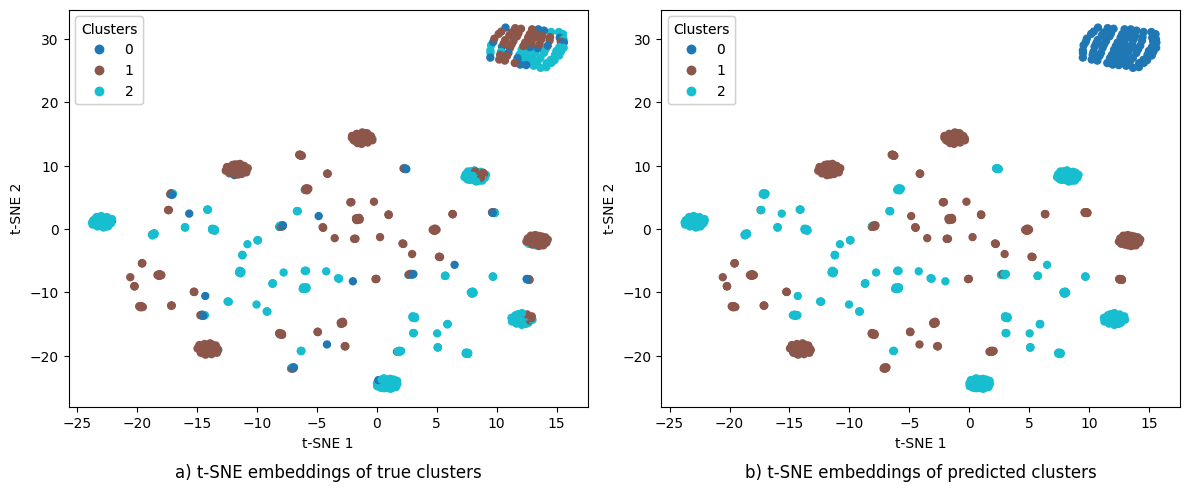

In [9]:
plot_clusters_2d(X, y_true, y_aligned, title_prefix="Dataset 11")
